/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/1c_qtc2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/2xes53qu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20576', 'data', 'file=/tmp/tmpci2fko9b/1c_qtc2x.json', 'init=/tmp/tmp

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5401
[LightGBM] [Info] Number of data points in the train set: 587, number of used features: 38
[LightGBM] [Info] Start training from score -0.027074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test RMSE: 0.6903232932090759
Test MAE: 0.2751534581184387


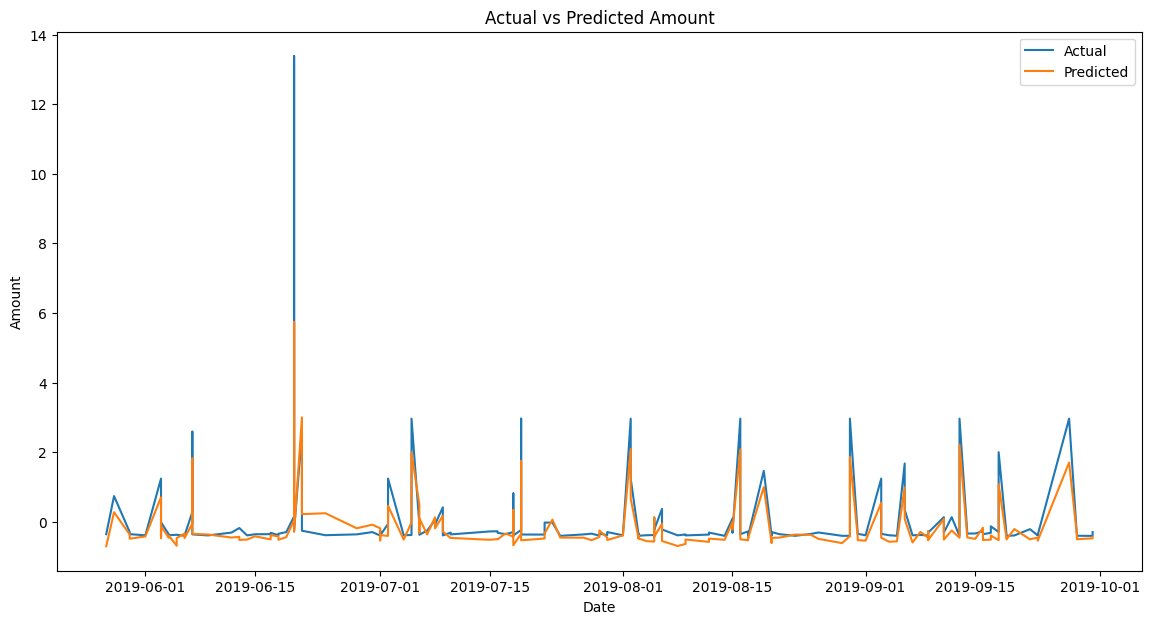

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib

# Load and preprocess data
df = pd.read_csv('/content/personal_transactions (1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df=df.drop('Account Name',axis=1)

le_dict = {}
for col in ['Transaction Type', 'Category', 'Description']:
    le_dict[col] = LabelEncoder()
    df[col] = le_dict[col].fit_transform(df[col])

scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Save preprocessors
joblib.dump(le_dict, 'label_encoders.joblib')
joblib.dump(scaler, 'scaler.joblib')

# Feature engineering function
def create_features(df):
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    for lag in [1, 3, 7, 14, 30]:
        df[f'Amount_lag_{lag}'] = df['Amount'].shift(lag)

    for window in [7, 14, 30]:
        df[f'Amount_rolling_mean_{window}'] = df['Amount'].rolling(window=window).mean()
        df[f'Amount_rolling_std_{window}'] = df['Amount'].rolling(window=window).std()

    for span in [7, 14, 30]:
        df[f'Amount_ema_{span}'] = df['Amount'].ewm(span=span).mean()

    for period in [7, 14, 30]:
        for order in [1, 2]:
            df[f'sin_{period}_{order}'] = np.sin(2 * np.pi * order * df.index / period)
            df[f'cos_{period}_{order}'] = np.cos(2 * np.pi * order * df.index / period)

    decomposition = seasonal_decompose(df['Amount'], model='additive', period=30, extrapolate_trend='freq')
    df['trend'] = decomposition.trend
    df['seasonal'] = decomposition.seasonal
    df['residual'] = decomposition.resid

    return df

df = create_features(df)
df = df.dropna()

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X.iloc[i:i+sequence_length].values)
        y_seq.append(y.iloc[i+sequence_length])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

sequence_length = 30
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Model creation functions
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def create_prophet_model(df):
    prophet_df = df[['Date', 'Amount']].rename(columns={'Date': 'ds', 'Amount': 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(prophet_df)
    return model

def create_xgboost_model():
    return XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

def create_lightgbm_model():
    return LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

def create_ensemble_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(16, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train-test split
train_end_date = '2019-04-30'
train_data = df[df['Date'] <= train_end_date]
test_data = df[df['Date'] > train_end_date]

X_train = train_data[features]
y_train = train_data['Amount']
X_test = test_data[features]
y_test = test_data['Amount']

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Train and save models
lstm_model = create_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]
lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=0)
lstm_model.save('lstm_model.h5')

prophet_model = create_prophet_model(train_data)
joblib.dump(prophet_model, 'prophet_model.joblib')

xgb_model = create_xgboost_model()
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, 'xgb_model.joblib')

lgbm_model = create_lightgbm_model()
lgbm_model.fit(X_train, y_train)
joblib.dump(lgbm_model, 'lgbm_model.joblib')

# Generate predictions
lstm_pred = lstm_model.predict(X_test_seq).flatten()
prophet_forecast = prophet_model.predict(prophet_model.make_future_dataframe(periods=len(test_data)))
prophet_pred = prophet_forecast.tail(len(test_data))['yhat'].values
xgb_pred = xgb_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)

# Ensure all predictions have the same length
min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
lstm_pred = lstm_pred[-min_length:]
prophet_pred = prophet_pred[-min_length:]
xgb_pred = xgb_pred[-min_length:]
lgbm_pred = lgbm_pred[-min_length:]
y_test_seq = y_test_seq[-min_length:]

# Create ensemble predictions
ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)
ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

ensemble_model = create_ensemble_model(ensemble_X.shape[1])
ensemble_model.fit(ensemble_X, y_test_seq, epochs=100, batch_size=32, verbose=0)
ensemble_model.save('ensemble_model.h5')

ensemble_pred = ensemble_model.predict(ensemble_X).flatten()

# Calculate test RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(y_test_seq, ensemble_pred))
test_mae = mean_absolute_error(y_test_seq, ensemble_pred)
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'].values[-min_length:], y_test_seq, label='Actual')
plt.plot(test_data['Date'].values[-min_length:], ensemble_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Actual vs Predicted Amount')
plt.legend()
plt.show()

# Save test results
results = pd.DataFrame({
    'Date': test_data['Date'][-min_length:],
    'Actual': scaler.inverse_transform(y_test[-min_length:].values.reshape(-1, 1)).flatten(),
    'Predicted': scaler.inverse_transform(ensemble_pred.reshape(-1, 1)).flatten()
})
results.to_csv('test_results.csv', index=False)

#Future Forecast

Failed to load LSTM model. Recreating model structure...
LSTM model structure recreated. Note: Weights are not loaded.
Failed to load ensemble model. Recreating model structure...
Ensemble model structure recreated. Note: Weights are not loaded.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Error during LSTM prediction: Exception encountered when calling LSTMCell.call().

Dimensions must be equal, but are 38 and 33 for '{{node sequential_1_1/lstm_2_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1_1/lstm_2_1/strided_slice_1, sequential_1_1/lstm_2_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [32,38], [33,256].

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(32, 38), dtype=float32)
  • states=('tf.Tensor(shape=(32, 64), dtype=float32)', 'tf.Tensor(shape=(32, 64), dtype=float32)')
  • training=False
Error during XGBoost prediction: feature_names mismatch: ['Transaction Type', 'Category', 'dayofweek', 'month', 'year', 'quarter', 'is_weekend', 'day_of_month', 'week_of_year', 'Amount_lag_1', 'Amount_lag_3', 'Amount_lag_7', 'Amount_lag_14', 'Amount_lag_30', 'Amount_rolling_mean_7', 'Amount_rolling_std_7', 'Amount_rolling_mean_14', 'Amount_rolling_std_14', 'Amount_rolling_mean_3

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


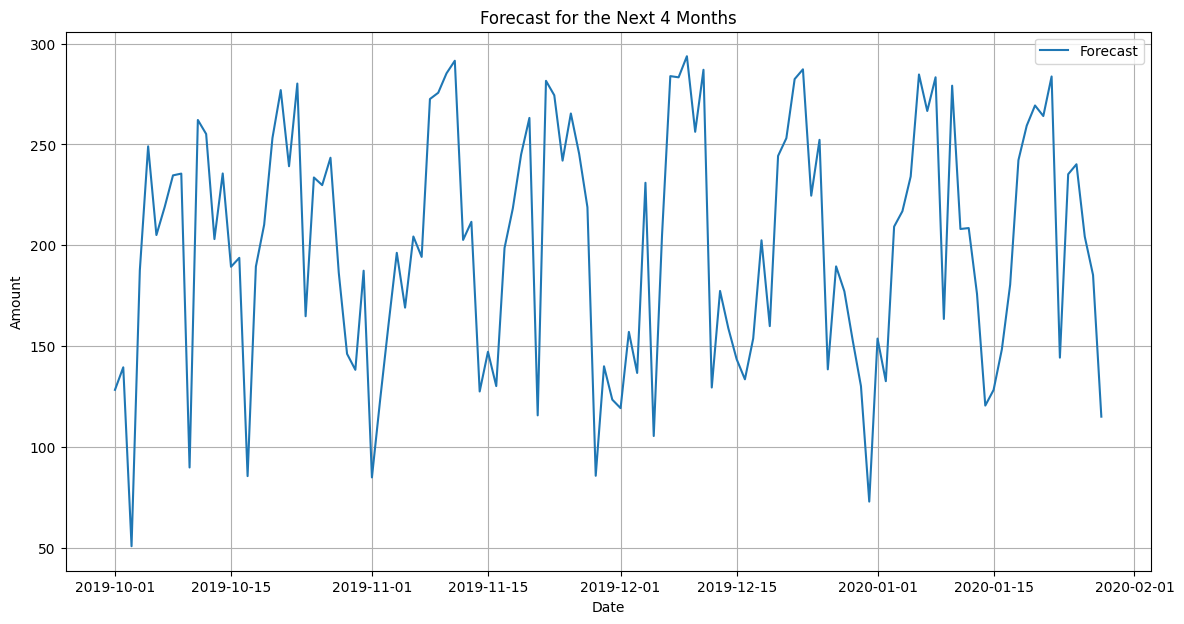

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from prophet import Prophet
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load preprocessors and models
le_dict = joblib.load('label_encoders.joblib')
scaler = joblib.load('scaler.joblib')

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Function to create ensemble model
def create_ensemble_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(16, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Try to load LSTM model, if fails, recreate the model structure
try:
    lstm_model = load_model('lstm_model.h5')
except:
    print("Failed to load LSTM model. Recreating model structure...")
    input_shape = (30, 33)  # Adjust this value based on your actual feature count
    lstm_model = create_lstm_model(input_shape)
    print("LSTM model structure recreated. Note: Weights are not loaded.")

# Try to load ensemble model, if fails, recreate the model structure
try:
    ensemble_model = load_model('ensemble_model.h5')
except:
    print("Failed to load ensemble model. Recreating model structure...")
    ensemble_input_shape = 4  # Adjust this value based on your actual input shape
    ensemble_model = create_ensemble_model(ensemble_input_shape)
    print("Ensemble model structure recreated. Note: Weights are not loaded.")

prophet_model = joblib.load('prophet_model.joblib')
xgb_model = joblib.load('xgb_model.joblib')
lgbm_model = joblib.load('lgbm_model.joblib')

# Load the last known data point
df = pd.read_csv('/content/personal_transactions (1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df=df.drop('Account Name',axis=1)

for col in ['Transaction Type', 'Category', 'Description']:
    df[col] = le_dict[col].transform(df[col])

# df['Amount'] = scaler.transform(df[['Amount']])

# Get the last known date and amount
last_date = df['Date'].max()
last_amount = df.loc[df['Date'] == last_date, 'Amount'].values[0]

def create_features(df, is_future=False):
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    # Only transform 'Transaction Type' and 'Category' if they exist in the dataframe
    for col in ['Transaction Type', 'Category']:
        if col in df.columns and col in le_dict:
            df[col] = le_dict[col].transform(df[col])
        elif col not in df.columns:
            # If the column doesn't exist, create a dummy column with a default value
            df[col] = 0  # or any other appropriate default value

    if not is_future:
        for lag in [1, 3, 7, 14, 30]:
            df[f'Amount_lag_{lag}'] = df['Amount'].shift(lag)

        for window in [7, 14, 30]:
            df[f'Amount_rolling_mean_{window}'] = df['Amount'].rolling(window=window).mean()
            df[f'Amount_rolling_std_{window}'] = df['Amount'].rolling(window=window).std()

        for span in [7, 14, 30]:
            df[f'Amount_ema_{span}'] = df['Amount'].ewm(span=span).mean()

        try:
            decomposition = seasonal_decompose(df['Amount'], model='additive', period=30, extrapolate_trend='freq')
            df['trend'] = decomposition.trend
            df['seasonal'] = decomposition.seasonal
            df['residual'] = decomposition.resid
        except:
            # If seasonal decomposition fails, create dummy columns
            df['trend'] = 0
            df['seasonal'] = 0
            df['residual'] = 0
    else:
        # For future data, we'll use the last known amount for these features
        for lag in [1, 3, 7, 14, 30]:
            df[f'Amount_lag_{lag}'] = last_amount

        for window in [7, 14, 30]:
            df[f'Amount_rolling_mean_{window}'] = last_amount
            df[f'Amount_rolling_std_{window}'] = 0  # Assuming no variation

        for span in [7, 14, 30]:
            df[f'Amount_ema_{span}'] = last_amount

        df['trend'] = 0
        df['seasonal'] = 0
        df['residual'] = 0

    for period in [7, 14, 30]:
        for order in [1, 2]:
            df[f'sin_{period}_{order}'] = np.sin(2 * np.pi * order * df.index / period)
            df[f'cos_{period}_{order}'] = np.cos(2 * np.pi * order * df.index / period)

    return df
# Remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'Amount')

# Function to create sequences
def create_sequences(X, sequence_length):
    X_seq = []
    for i in range(len(X) - sequence_length + 1):
        X_seq.append(X.iloc[i:i + sequence_length].values)
    return np.array(X_seq, dtype=np.float32)

# Generate future dates
def generate_future_dates(last_date, num_months):
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_months * 30, freq='D')
    return future_dates

def forecast_future(num_months):
    future_dates = generate_future_dates(last_date, num_months)
    future_df = pd.DataFrame({'Date': future_dates})

    # Create features for future dates
    future_df = create_features(future_df, is_future=True)

    # Prepare data for LSTM
    sequence_length = 30
    X_future = future_df.drop('Date', axis=1)
    X_future_seq = create_sequences(X_future, sequence_length)

    # Ensure consistent lengths for predictions
    try:
        lstm_pred = lstm_model.predict(X_future_seq).flatten()
    except Exception as e:
        print("Error during LSTM prediction:", e)
        lstm_pred = np.zeros(len(future_dates))  # Handle error case

    prophet_future = prophet_model.make_future_dataframe(periods=len(future_dates))
    prophet_forecast = prophet_model.predict(prophet_future)
    prophet_pred = prophet_forecast.tail(len(future_dates))['yhat'].values

    try:
        xgb_pred = xgb_model.predict(X_future)
    except ValueError as e:
        print("Error during XGBoost prediction:", e)
        xgb_pred = np.zeros(len(future_dates))  # Handle error case

    try:
        lgbm_pred = lgbm_model.predict(X_future)
    except ValueError as e:
        print("Error during LightGBM prediction:", e)
        lgbm_pred = np.zeros(len(future_dates))  # Handle error case

    # Adjust lengths if necessary
    if len(lstm_pred) != len(future_dates):
        lstm_pred = np.resize(lstm_pred, len(future_dates))
    if len(prophet_pred) != len(future_dates):
        prophet_pred = np.resize(prophet_pred, len(future_dates))
    if len(xgb_pred) != len(future_dates):
        xgb_pred = np.resize(xgb_pred, len(future_dates))
    if len(lgbm_pred) != len(future_dates):
        lgbm_pred = np.resize(lgbm_pred, len(future_dates))

    # Combine predictions for ensemble
    ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)

    # Make ensemble prediction
    try:
        ensemble_pred = ensemble_model.predict(ensemble_X).flatten()
    except Exception as e:
        print("Error during ensemble prediction:", e)
        ensemble_pred = np.zeros(len(future_dates))  # Handle error case

    # Inverse transform the predictions
    final_pred = scaler.inverse_transform(ensemble_pred.reshape(-1, 1)).flatten()

    return future_dates, final_pred

# Get user input for the number of months to forecast
num_months = 4
# Generate forecast
future_dates, forecast = forecast_future(num_months)

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(future_dates, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title(f'Forecast for the Next {num_months} Months')
plt.legend()
plt.grid(True)
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/6d649se9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/szjyy7wi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17634', 'data', 'file=/tmp/tmpci2fko9b/6d649se9.json', 'init=/tmp/tmpci2fko9b/szjyy7wi.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_model0qesko8u/prophet_model-20240821053125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5401
[LightGBM] [Info] Number of data points in the train set: 587, number of used features: 38
[LightGBM] [Info] Start training from score -0.027074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

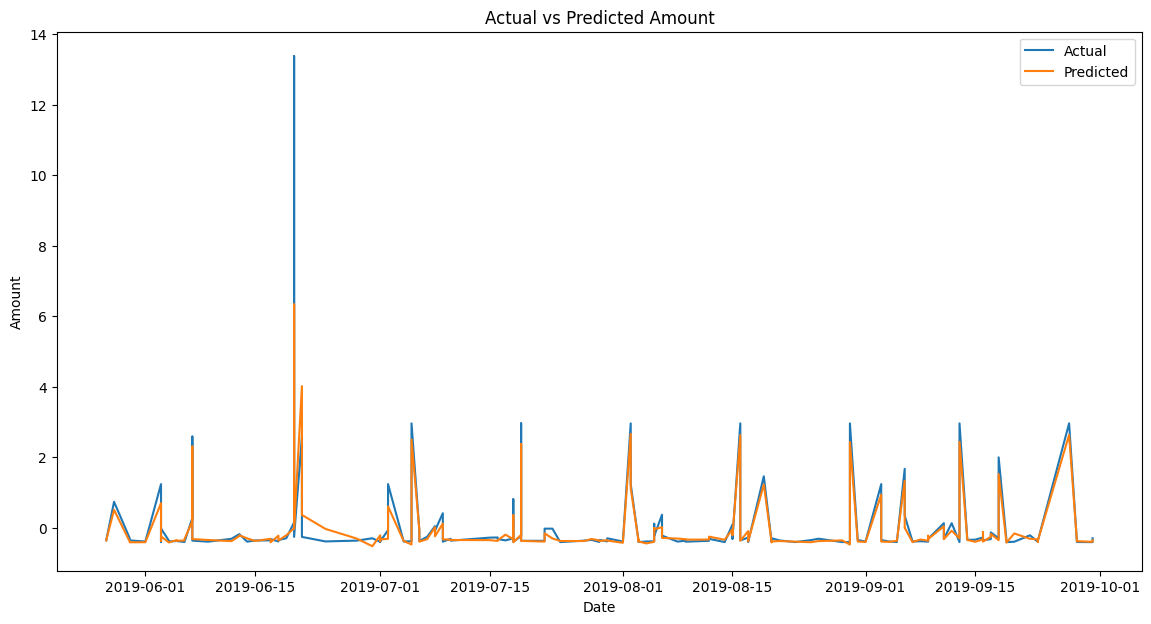

['feature_names.joblib']

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib

# Load and preprocess data
df = pd.read_csv('/content/personal_transactions (1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.drop('Account Name', axis=1)

le_dict = {}
for col in ['Transaction Type', 'Category', 'Description']:
    le_dict[col] = LabelEncoder()
    df[col] = le_dict[col].fit_transform(df[col])

scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Save preprocessors
joblib.dump(le_dict, 'label_encoders.joblib')
joblib.dump(scaler, 'scaler.joblib')

# Feature engineering function
def create_features(df):
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    for lag in [1, 3, 7, 14, 30]:
        df[f'Amount_lag_{lag}'] = df['Amount'].shift(lag)

    for window in [7, 14, 30]:
        df[f'Amount_rolling_mean_{window}'] = df['Amount'].rolling(window=window).mean()
        df[f'Amount_rolling_std_{window}'] = df['Amount'].rolling(window=window).std()

    for span in [7, 14, 30]:
        df[f'Amount_ema_{span}'] = df['Amount'].ewm(span=span).mean()

    for period in [7, 14, 30]:
        for order in [1, 2]:
            df[f'sin_{period}_{order}'] = np.sin(2 * np.pi * order * df.index / period)
            df[f'cos_{period}_{order}'] = np.cos(2 * np.pi * order * df.index / period)

    decomposition = seasonal_decompose(df['Amount'], model='additive', period=30, extrapolate_trend='freq')
    df['trend'] = decomposition.trend
    df['seasonal'] = decomposition.seasonal
    df['residual'] = decomposition.resid

    return df

df = create_features(df)
df = df.dropna()

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X.iloc[i:i+sequence_length].values)
        y_seq.append(y.iloc[i+sequence_length])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

sequence_length = 30
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Model creation functions
def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, activation='relu', return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = LSTM(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


def create_prophet_model(df):
    prophet_df = df[['Date', 'Amount']].rename(columns={'Date': 'ds', 'Amount': 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(prophet_df)
    return model

def create_xgboost_model():
    return XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

def create_lightgbm_model():
    return LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

def create_ensemble_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(16, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train-test split
train_end_date = '2019-04-30'
train_data = df[df['Date'] <= train_end_date]
test_data = df[df['Date'] > train_end_date]

X_train = train_data[features]
y_train = train_data['Amount']
X_test = test_data[features]
y_test = test_data['Amount']

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Train and save models
lstm_model = create_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]
lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=0)
lstm_model.save('lstm_model.keras')

prophet_model = create_prophet_model(train_data)
joblib.dump(prophet_model, 'prophet_model.pkl')

xgb_model = create_xgboost_model()
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, 'xgb_model.pkl')

lgbm_model = create_lightgbm_model()
lgbm_model.fit(X_train, y_train)
joblib.dump(lgbm_model, 'lgbm_model.pkl')

# Generate predictions
lstm_pred = lstm_model.predict(X_test_seq).flatten()
prophet_forecast = prophet_model.predict(prophet_model.make_future_dataframe(periods=len(test_data)))
prophet_pred = prophet_forecast.tail(len(test_data))['yhat'].values
xgb_pred = xgb_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)

# Ensure all predictions have the same length
min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
lstm_pred = lstm_pred[-min_length:]
prophet_pred = prophet_pred[-min_length:]
xgb_pred = xgb_pred[-min_length:]
lgbm_pred = lgbm_pred[-min_length:]
y_test_seq = y_test_seq[-min_length:]

# Create ensemble predictions
ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)
ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

ensemble_model = create_ensemble_model(ensemble_X.shape[1])
ensemble_model.fit(ensemble_X, y_test_seq, epochs=100, batch_size=32, verbose=0)
ensemble_model.save('ensemble_model.keras')

ensemble_pred = ensemble_model.predict(ensemble_X).flatten()

# Calculate test RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(y_test_seq, ensemble_pred))
test_mae = mean_absolute_error(y_test_seq, ensemble_pred)
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'].values[-min_length:], y_test_seq, label='Actual')
plt.plot(test_data['Date'].values[-min_length:], ensemble_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Actual vs Predicted Amount')
plt.legend()
plt.show()

# Save test results
results = pd.DataFrame({
    'Date': test_data['Date'][-min_length:],
    'Actual': scaler.inverse_transform(y_test[-min_length:].values.reshape(-1, 1)).flatten(),
    'Predicted': scaler.inverse_transform(ensemble_pred.reshape(-1, 1)).flatten()
})
results.to_csv('test_results.csv', index=False)

# Save feature names
joblib.dump(features, 'feature_names.joblib')

#Future Forecast

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


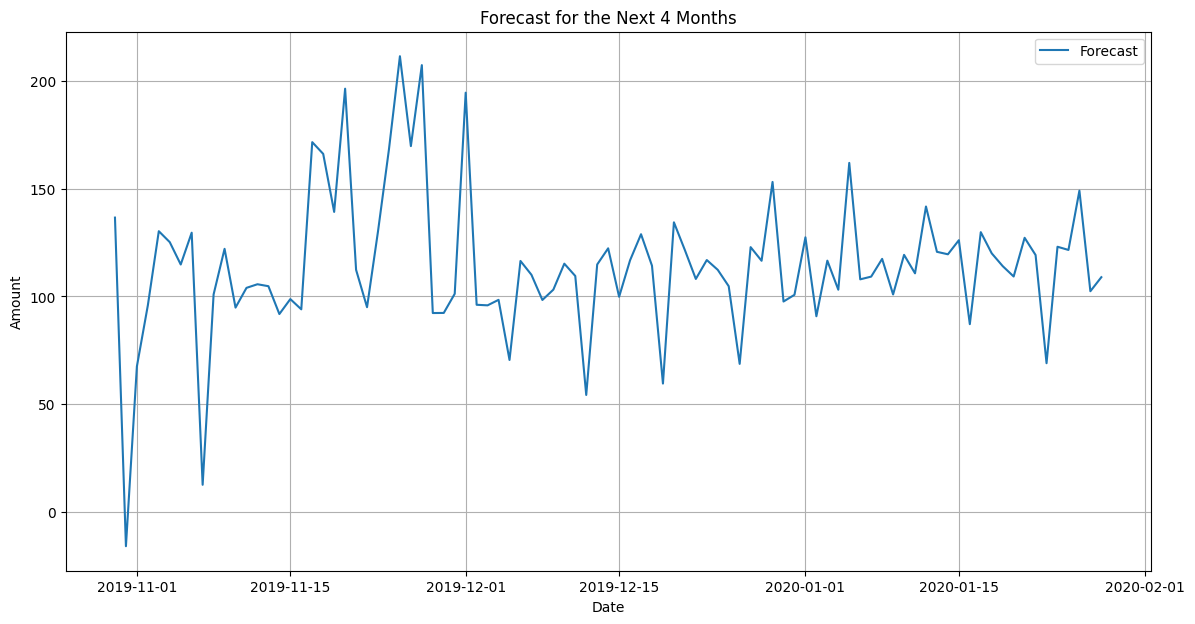

In [8]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from prophet import Prophet
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Load preprocessors and models
le_dict = joblib.load('label_encoders.joblib')
scaler = joblib.load('scaler.joblib')
features = joblib.load('feature_names.joblib')

# Load models
lstm_model = load_model('lstm_model.keras')
prophet_model = joblib.load('prophet_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')
lgbm_model = joblib.load('lgbm_model.pkl')
ensemble_model = load_model('ensemble_model.keras')

# Load the last known data point
df = pd.read_csv('/content/personal_transactions (1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop('Account Name', axis=1)

for col in ['Transaction Type', 'Category', 'Description']:
    df[col] = le_dict[col].transform(df[col])

df['Amount'] = scaler.transform(df[['Amount']])

# Get the last known date and amount
last_date = df['Date'].max()
last_amount = df.loc[df['Date'] == last_date, 'Amount'].values[0]

def create_features(df, is_future=False):
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    if not is_future:
        for col in ['Transaction Type', 'Category', 'Description']:
            if col in df.columns:
                df[col] = le_dict[col].transform(df[col])
    else:
        # For future data, we'll use dummy values
        for col in ['Transaction Type', 'Category', 'Description']:
            df[col] = 0  # or any other appropriate default value

    if not is_future:
        for lag in [1, 3, 7, 14, 30]:
            df[f'Amount_lag_{lag}'] = df['Amount'].shift(lag)

        for window in [7, 14, 30]:
            df[f'Amount_rolling_mean_{window}'] = df['Amount'].rolling(window=window).mean()
            df[f'Amount_rolling_std_{window}'] = df['Amount'].rolling(window=window).std()

        for span in [7, 14, 30]:
            df[f'Amount_ema_{span}'] = df['Amount'].ewm(span=span).mean()

        try:
            decomposition = seasonal_decompose(df['Amount'], model='additive', period=30, extrapolate_trend='freq')
            df['trend'] = decomposition.trend
            df['seasonal'] = decomposition.seasonal
            df['residual'] = decomposition.resid
        except:
            df['trend'] = 0
            df['seasonal'] = 0
            df['residual'] = 0
    else:
        for lag in [1, 3, 7, 14, 30]:
            df[f'Amount_lag_{lag}'] = last_amount

        for window in [7, 14, 30]:
            df[f'Amount_rolling_mean_{window}'] = last_amount
            df[f'Amount_rolling_std_{window}'] = 0

        for span in [7, 14, 30]:
            df[f'Amount_ema_{span}'] = last_amount

        df['trend'] = 0
        df['seasonal'] = 0
        df['residual'] = 0

    for period in [7, 14, 30]:
        for order in [1, 2]:
            df[f'sin_{period}_{order}'] = np.sin(2 * np.pi * order * df.index / period)
            df[f'cos_{period}_{order}'] = np.cos(2 * np.pi * order * df.index / period)

    return df

def create_sequences(X, sequence_length):
    X_seq = []
    for i in range(len(X) - sequence_length + 1):
        X_seq.append(X.iloc[i:i + sequence_length].values)
    return np.array(X_seq, dtype=np.float32)

def generate_future_dates(last_date, num_months):
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_months * 30, freq='D')
    return future_dates


def forecast_future(num_months):
    future_dates = generate_future_dates(last_date, num_months)
    future_df = pd.DataFrame({'Date': future_dates})

    future_df = create_features(future_df, is_future=True)

    sequence_length = 30
    X_future = future_df[features]
    X_future_seq = create_sequences(X_future, sequence_length)

    lstm_pred = lstm_model.predict(X_future_seq).flatten()
    prophet_forecast = prophet_model.predict(prophet_model.make_future_dataframe(periods=len(future_dates)))
    prophet_pred = prophet_forecast.tail(len(future_dates))['yhat'].values
    xgb_pred = xgb_model.predict(X_future)
    lgbm_pred = lgbm_model.predict(X_future)

    min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
    lstm_pred = lstm_pred[-min_length:]
    prophet_pred = prophet_pred[-min_length:]
    xgb_pred = xgb_pred[-min_length:]
    lgbm_pred = lgbm_pred[-min_length:]

    ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)
    ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

    ensemble_pred = ensemble_model.predict(ensemble_X).flatten()

    final_pred = scaler.inverse_transform(ensemble_pred.reshape(-1, 1)).flatten()

    return future_dates[-min_length:], final_pred

# Get user input for the number of months to forecast
num_months = 4
# Generate forecast
future_dates, forecast = forecast_future(num_months)

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(future_dates, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title(f'Forecast for the Next {num_months} Months')
plt.legend()
plt.grid(True)
plt.show()

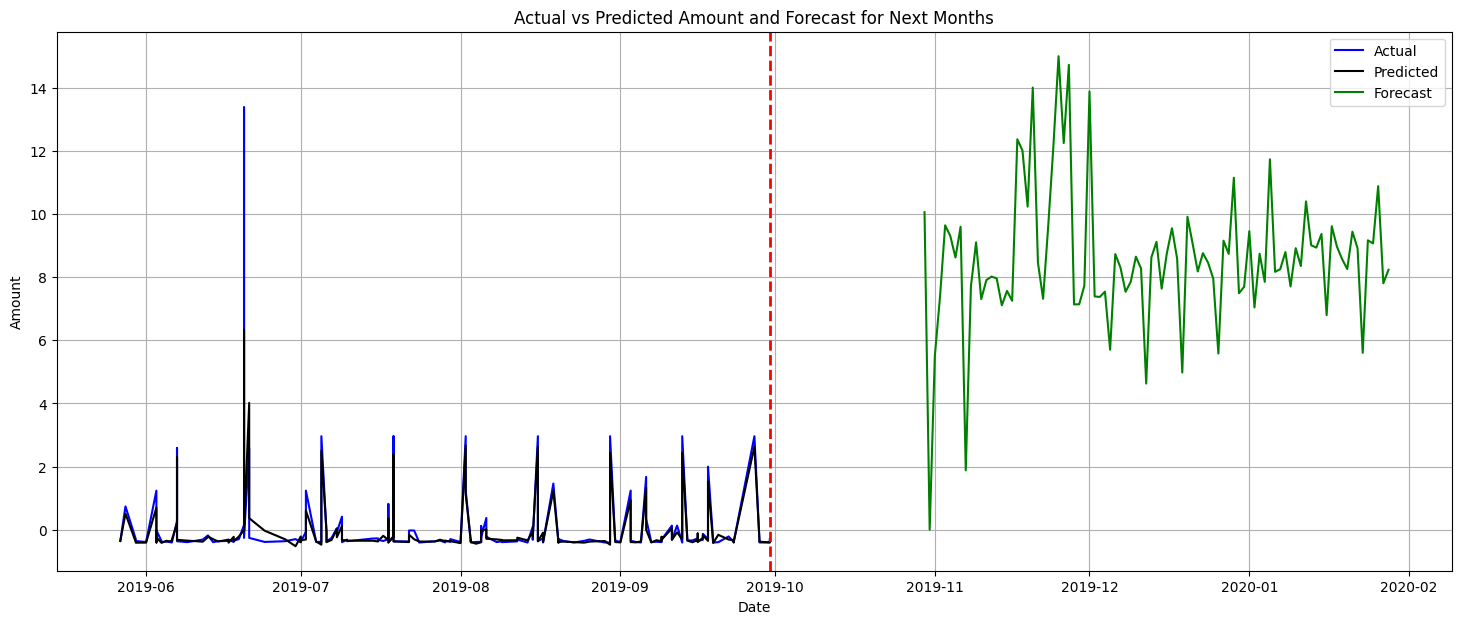

In [18]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Data for the first graph (Actual vs Predicted)
min_length = min(len(y_test_seq), len(ensemble_pred))
dates_actual = test_data['Date'].values[-min_length:]
actual_values = y_test_seq
predicted_values = ensemble_pred

# Scaling for the second graph (Forecast)
scaler = MinMaxScaler(feature_range=(0, 15))
forecast_scaled = scaler.fit_transform(forecast.reshape(-1, 1)).flatten()

# Create a figure and axis
plt.figure(figsize=(18, 7))

# Plot the first graph (Actual vs Predicted)
plt.plot(dates_actual, actual_values, label='Actual', color='blue')
plt.plot(dates_actual, predicted_values, label='Predicted', color='black')

# Plot the red vertical line to separate the graphs
plt.axvline(x=dates_actual[-1], color='red', linewidth=2, linestyle='--')

# Plot the second graph (Forecast) right after the first graph
# Using the future dates as the x-axis and scaled forecast as the y-axis
plt.plot(future_dates, forecast_scaled, label='Forecast', color='green')

# Labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Actual vs Predicted Amount and Forecast for Next Months')
plt.legend()
plt.grid(True)

# Show the combined plot
plt.show()


#Sub Categories

In [19]:
import pandas as pd
import os

# Read the CSV file
df = pd.read_csv('/content/personal_transactions (1).csv')

# Group by Category and count the records
category_counts = df['Category'].value_counts()

# Filter categories with more than 60 records
categories_above_60 = category_counts[category_counts > 60].index

# Create a folder to save the new CSV files
output_folder = 'category_subsets'
os.makedirs(output_folder, exist_ok=True)

# Create separate CSV files for each category with more than 60 records
for category in categories_above_60:
    subset = df[df['Category'] == category]
    output_file = os.path.join(output_folder, f'{category}.csv')
    subset.to_csv(output_file, index=False)
    print(f"Created file: {output_file}")

print("Process completed.")

Created file: category_subsets/Credit Card Payment.csv
Created file: category_subsets/Groceries.csv
Created file: category_subsets/Restaurants.csv
Created file: category_subsets/Utilities.csv
Process completed.


#Credit Card Payment


Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/_i5sqqsq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/sn1dxjv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13115', 'data', 'file=/tmp/tmpci2fko9b/_i5sqqsq.json', 'init=/tmp/tmpci2fko9b/sn1dxjv4.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelok5xkomy/prophet_model-20240821074047.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:40:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Info] Start training from score -0.334171
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/3zsbk12r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/i7sfzog5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47807', 'data', 'file=/tmp/tmpci2fko9b/3zsbk12r.json', 'init=/tmp/tmpci2fko9b/i7sfzog5.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelllo13tg5/prophet_model-20240821074102.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:41:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score -0.430946
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/udq8wg25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/ksw_3faw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46258', 'data', 'file=/tmp/tmpci2fko9b/udq8wg25.json', 'init=/tmp/tmpci2fko9b/ksw_3faw.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelwoq7k81y/prophet_model-20240821074120.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:41:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 33
[LightGBM] [Info] Start training from score -0.351737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/whxmc1ct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/9w4zezhs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66863', 'data', 'file=/tmp/tmpci2fko9b/whxmc1ct.json', 'init=/tmp/tmpci2fko9b/9w4zezhs.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelqchjppr6/prophet_model-20240821074148.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:41:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 35
[LightGBM] [Info] Start training from score -0.234968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/wqyyljmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/tvg1kv6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53090', 'data', 'file=/tmp/tmpci2fko9b/wqyyljmu.json', 'init=/tmp/tmpci2fko9b/tvg1kv6p.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelnhg30ame/prophet_model-20240821074212.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:42:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 70, number of used features: 37
[LightGBM] [Info] Start training from score -0.135287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/3ecbkfk3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/4qmaaxfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99748', 'data', 'file=/tmp/tmpci2fko9b/3ecbkfk3.json', 'init=/tmp/tmpci2fko9b/4qmaaxfk.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_model3l_094w6/prophet_model-20240821074306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 113, number of used features: 37
[LightGBM] [Info] Start training from score -0.098861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

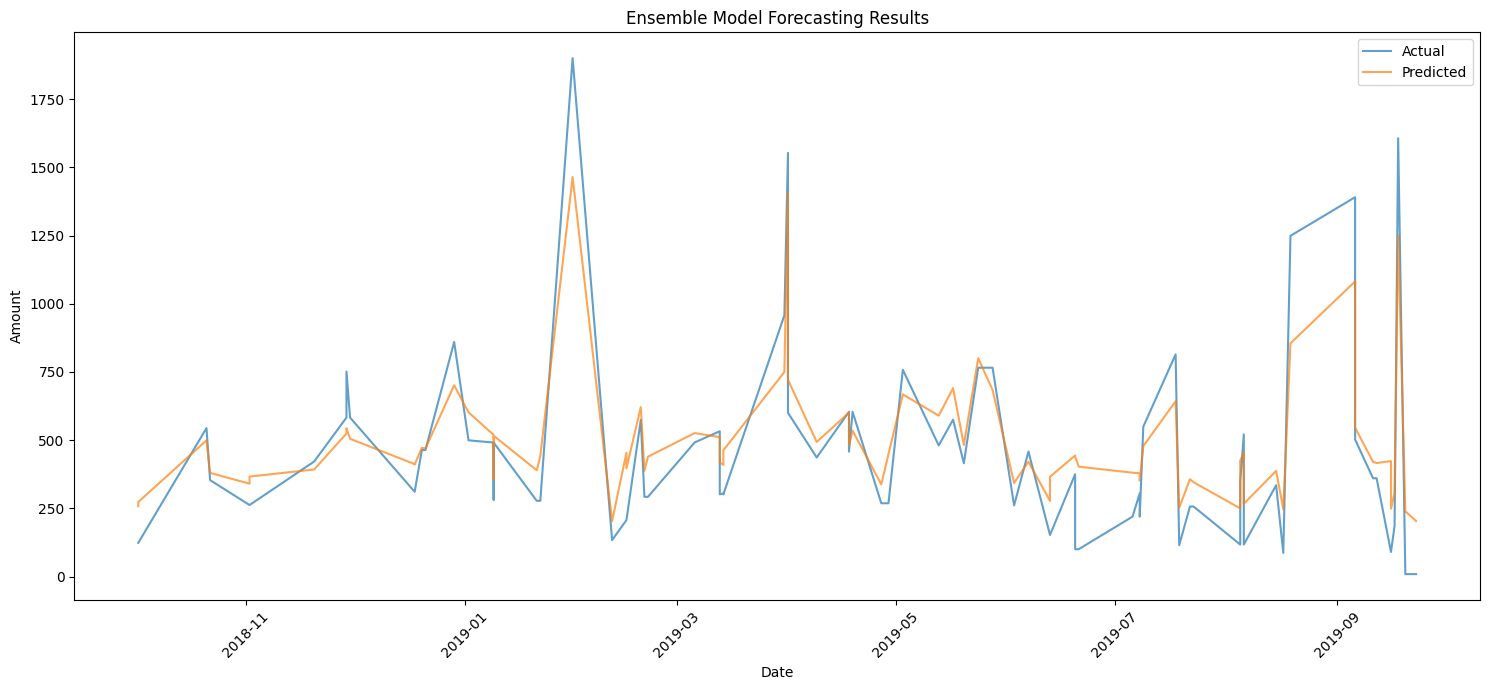

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load and preprocess data
df = pd.read_csv('/content/category_subsets/Credit Card Payment.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Encode categorical features
le_dict = {}
for col in ['Transaction Type', 'Category', 'Account Name']:
    le_dict[col] = LabelEncoder()
    df[col] = le_dict[col].fit_transform(df[col])

# Normalize 'Amount'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Advanced feature engineering
def create_features(df):
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    # Lag features
    for lag in [1, 3, 7, 14, 30]:
        df[f'Amount_lag_{lag}'] = df['Amount'].shift(lag)

    # Rolling statistics
    for window in [7, 14, 30]:
        df[f'Amount_rolling_mean_{window}'] = df['Amount'].rolling(window=window).mean()
        df[f'Amount_rolling_std_{window}'] = df['Amount'].rolling(window=window).std()

    # Exponential moving average
    for span in [7, 14, 30]:
        df[f'Amount_ema_{span}'] = df['Amount'].ewm(span=span).mean()

    # Fourier features
    for period in [7, 14, 30]:
        for order in [1, 2]:
            df[f'sin_{period}_{order}'] = np.sin(2 * np.pi * order * df.index / period)
            df[f'cos_{period}_{order}'] = np.cos(2 * np.pi * order * df.index / period)

    # Seasonal decomposition
    decomposition = seasonal_decompose(df['Amount'], model='additive', period=30, extrapolate_trend='freq')
    df['trend'] = decomposition.trend
    df['seasonal'] = decomposition.seasonal
    df['residual'] = decomposition.resid

    return df

df = create_features(df)
df = df.dropna()

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X.iloc[i:i+sequence_length].values)
        y_seq.append(y.iloc[i+sequence_length])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

# ... (keep the rest of the code before this point unchanged)

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

sequence_length = 30
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Modify the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


# Prophet model
def create_prophet_model(df):
    prophet_df = df[['Date', 'Amount']].rename(columns={'Date': 'ds', 'Amount': 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(prophet_df)
    return model

# XGBoost model
def create_xgboost_model():
    return XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# LightGBM model
def create_lightgbm_model():
    return LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# Ensemble model
def create_ensemble_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(16, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

rmse_scores = []
for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\nFold {fold + 1}")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # LSTM
    lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
    ]
    history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=0)
    lstm_pred = lstm_model.predict(X_test).flatten()

    # Prophet
    prophet_df = df.iloc[train_index].reset_index(drop=True)
    prophet_df = prophet_df[['Date', 'Amount']].rename(columns={'Date': 'ds', 'Amount': 'y'})
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=len(test_index))
    prophet_forecast = prophet_model.predict(future)
    prophet_pred = prophet_forecast.tail(len(test_index))['yhat'].values

    # XGBoost
    xgb_model = create_xgboost_model()
    xgb_model.fit(X.iloc[train_index], y.iloc[train_index])
    xgb_pred = xgb_model.predict(X.iloc[test_index])

    # LightGBM
    lgbm_model = create_lightgbm_model()
    lgbm_model.fit(X.iloc[train_index], y.iloc[train_index])
    lgbm_pred = lgbm_model.predict(X.iloc[test_index])

    # Ensure all predictions have the same length
    min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
    lstm_pred = lstm_pred[-min_length:]
    prophet_pred = prophet_pred[-min_length:]
    xgb_pred = xgb_pred[-min_length:]
    lgbm_pred = lgbm_pred[-min_length:]
    y_test = y_test[-min_length:]

    # Create ensemble_X
    ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)

    # Handle NaN values
    ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

    # Create and fit the ensemble model
    ensemble_model = create_ensemble_model(ensemble_X.shape[1])
    ensemble_model.fit(ensemble_X, y_test, epochs=100, batch_size=32, verbose=0)
    ensemble_pred = ensemble_model.predict(ensemble_X).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    rmse_scores.append(rmse)
    print(f"Fold RMSE: {rmse}")

print(f"\nAverage RMSE: {np.mean(rmse_scores)}")

# Final prediction on the entire dataset
lstm_model = create_lstm_model((X_seq.shape[1], X_seq.shape[2]))
lstm_model.fit(X_seq, y_seq, epochs=100, batch_size=32, callbacks=callbacks, verbose=0)
lstm_pred = lstm_model.predict(X_seq).flatten()

prophet_model = create_prophet_model(df)
prophet_forecast = prophet_model.predict(prophet_model.make_future_dataframe(periods=0))
prophet_pred = prophet_forecast['yhat'].values

xgb_model = create_xgboost_model()
xgb_model.fit(X, y)
xgb_pred = xgb_model.predict(X)

lgbm_model = create_lightgbm_model()
lgbm_model.fit(X, y)
lgbm_pred = lgbm_model.predict(X)

# Ensure all predictions have the same length
min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
lstm_pred = lstm_pred[-min_length:]
prophet_pred = prophet_pred[-min_length:]
xgb_pred = xgb_pred[-min_length:]
lgbm_pred = lgbm_pred[-min_length:]

ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)
ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

ensemble_model = create_ensemble_model(ensemble_X.shape[1])
ensemble_model.fit(ensemble_X, y[-min_length:], epochs=100, batch_size=32, verbose=0)
final_pred = ensemble_model.predict(ensemble_X).flatten()

# Prepare results
results = pd.DataFrame({
    'Date': df['Date'].iloc[-min_length:],
    'Description': df['Description'].iloc[-min_length:],
    'Actual': scaler.inverse_transform(y[-min_length:].values.reshape(-1, 1)).flatten(),
    'Predicted': scaler.inverse_transform(final_pred.reshape(-1, 1)).flatten()
})

for col in ['Transaction Type', 'Category', 'Account Name']:
    results[col] = le_dict[col].inverse_transform(df[col].iloc[-min_length:])

results.to_csv('forecasting_results.csv', index=False)

# Visualization
plt.figure(figsize=(15, 7))
plt.plot(results['Date'], results['Actual'], label='Actual', alpha=0.7)
plt.plot(results['Date'], results['Predicted'], label='Predicted', alpha=0.7)
plt.title('Ensemble Model Forecasting Results')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Groceries


Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/fn4ijycj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/7kpfvyz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67284', 'data', 'file=/tmp/tmpci2fko9b/fn4ijycj.json', 'init=/tmp/tmpci2fko9b/7kpfvyz8.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelfsm1gsln/prophet_model-20240821074347.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:43:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 10, number of used features: 0
[LightGBM] [Info] Start training from score -0.325602
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/fipva8mu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/bcy7odwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94002', 'data', 'file=/tmp/tmpci2fko9b/fipva8mu.json', 'init=/tmp/tmpci2fko9b/bcy7odwb.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_model0m5y4wt6/prophet_model-20240821074404.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:44:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 17, number of used features: 0
[LightGBM] [Info] Start training from score -0.396593
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/gwuc4v_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/9lh0ihrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3017', 'data', 'file=/tmp/tmpci2fko9b/gwuc4v_6.json', 'init=/tmp/tmpci2fko9b/9lh0ihrh.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modela3bvofuu/prophet_model-20240821074419.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:44:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 0
[LightGBM] [Info] Start training from score -0.352852
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/_9ze5v9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/5ij7bf74.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56461', 'data', 'file=/tmp/tmpci2fko9b/_9ze5v9r.json', 'init=/tmp/tmpci2fko9b/5ij7bf74.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelcb3wj0lx/prophet_model-20240821074437.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:44:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score -0.315564
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/4v1ha7dm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/5hyjmhyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97221', 'data', 'file=/tmp/tmpci2fko9b/4v1ha7dm.json', 'init=/tmp/tmpci2fko9b/5hyjmhyk.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelv1c0uffb/prophet_model-20240821074452.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:44:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 38, number of used features: 0
[LightGBM] [Info] Start training from score -0.210542
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/nqz4tbw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/0ntzbawa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2413', 'data', 'file=/tmp/tmpci2fko9b/nqz4tbw6.json', 'init=/tmp/tmpci2fko9b/0ntzbawa.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_models7auvk47/prophet_model-20240821074513.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:45:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 36
[LightGBM] [Info] Start training from score -0.062602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

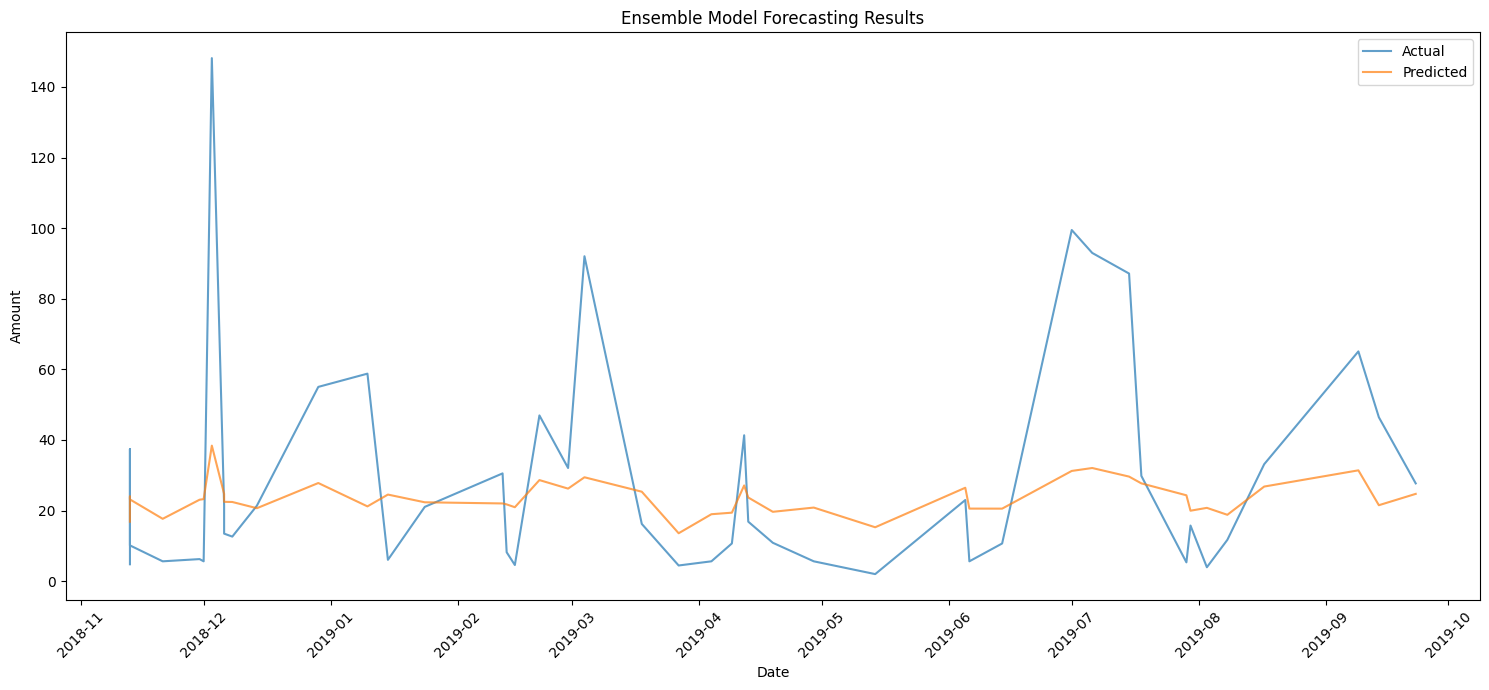

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load and preprocess data
df = pd.read_csv('/content/category_subsets/Groceries.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Encode categorical features
le_dict = {}
for col in ['Transaction Type', 'Category', 'Account Name']:
    le_dict[col] = LabelEncoder()
    df[col] = le_dict[col].fit_transform(df[col])

# Normalize 'Amount'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Advanced feature engineering
def create_features(df):
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    # Lag features
    for lag in [1, 3, 7, 14, 30]:
        df[f'Amount_lag_{lag}'] = df['Amount'].shift(lag)

    # Rolling statistics
    for window in [7, 14, 30]:
        df[f'Amount_rolling_mean_{window}'] = df['Amount'].rolling(window=window).mean()
        df[f'Amount_rolling_std_{window}'] = df['Amount'].rolling(window=window).std()

    # Exponential moving average
    for span in [7, 14, 30]:
        df[f'Amount_ema_{span}'] = df['Amount'].ewm(span=span).mean()

    # Fourier features
    for period in [7, 14, 30]:
        for order in [1, 2]:
            df[f'sin_{period}_{order}'] = np.sin(2 * np.pi * order * df.index / period)
            df[f'cos_{period}_{order}'] = np.cos(2 * np.pi * order * df.index / period)

    # Seasonal decomposition
    decomposition = seasonal_decompose(df['Amount'], model='additive', period=30, extrapolate_trend='freq')
    df['trend'] = decomposition.trend
    df['seasonal'] = decomposition.seasonal
    df['residual'] = decomposition.resid

    return df

df = create_features(df)
df = df.dropna()

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X.iloc[i:i+sequence_length].values)
        y_seq.append(y.iloc[i+sequence_length])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

# ... (keep the rest of the code before this point unchanged)

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

sequence_length = 30
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Modify the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


# Prophet model
def create_prophet_model(df):
    prophet_df = df[['Date', 'Amount']].rename(columns={'Date': 'ds', 'Amount': 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(prophet_df)
    return model

# XGBoost model
def create_xgboost_model():
    return XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# LightGBM model
def create_lightgbm_model():
    return LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# Ensemble model
def create_ensemble_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(16, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

rmse_scores = []
for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\nFold {fold + 1}")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # LSTM
    lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
    ]
    history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=0)
    lstm_pred = lstm_model.predict(X_test).flatten()

    # Prophet
    prophet_df = df.iloc[train_index].reset_index(drop=True)
    prophet_df = prophet_df[['Date', 'Amount']].rename(columns={'Date': 'ds', 'Amount': 'y'})
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=len(test_index))
    prophet_forecast = prophet_model.predict(future)
    prophet_pred = prophet_forecast.tail(len(test_index))['yhat'].values

    # XGBoost
    xgb_model = create_xgboost_model()
    xgb_model.fit(X.iloc[train_index], y.iloc[train_index])
    xgb_pred = xgb_model.predict(X.iloc[test_index])

    # LightGBM
    lgbm_model = create_lightgbm_model()
    lgbm_model.fit(X.iloc[train_index], y.iloc[train_index])
    lgbm_pred = lgbm_model.predict(X.iloc[test_index])

    # Ensure all predictions have the same length
    min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
    lstm_pred = lstm_pred[-min_length:]
    prophet_pred = prophet_pred[-min_length:]
    xgb_pred = xgb_pred[-min_length:]
    lgbm_pred = lgbm_pred[-min_length:]
    y_test = y_test[-min_length:]

    # Create ensemble_X
    ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)

    # Handle NaN values
    ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

    # Create and fit the ensemble model
    ensemble_model = create_ensemble_model(ensemble_X.shape[1])
    ensemble_model.fit(ensemble_X, y_test, epochs=100, batch_size=32, verbose=0)
    ensemble_pred = ensemble_model.predict(ensemble_X).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    rmse_scores.append(rmse)
    print(f"Fold RMSE: {rmse}")

print(f"\nAverage RMSE: {np.mean(rmse_scores)}")

# Final prediction on the entire dataset
lstm_model = create_lstm_model((X_seq.shape[1], X_seq.shape[2]))
lstm_model.fit(X_seq, y_seq, epochs=100, batch_size=32, callbacks=callbacks, verbose=0)
lstm_pred = lstm_model.predict(X_seq).flatten()

prophet_model = create_prophet_model(df)
prophet_forecast = prophet_model.predict(prophet_model.make_future_dataframe(periods=0))
prophet_pred = prophet_forecast['yhat'].values

xgb_model = create_xgboost_model()
xgb_model.fit(X, y)
xgb_pred = xgb_model.predict(X)

lgbm_model = create_lightgbm_model()
lgbm_model.fit(X, y)
lgbm_pred = lgbm_model.predict(X)

# Ensure all predictions have the same length
min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
lstm_pred = lstm_pred[-min_length:]
prophet_pred = prophet_pred[-min_length:]
xgb_pred = xgb_pred[-min_length:]
lgbm_pred = lgbm_pred[-min_length:]

ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)
ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

ensemble_model = create_ensemble_model(ensemble_X.shape[1])
ensemble_model.fit(ensemble_X, y[-min_length:], epochs=100, batch_size=32, verbose=0)
final_pred = ensemble_model.predict(ensemble_X).flatten()

# Prepare results
results = pd.DataFrame({
    'Date': df['Date'].iloc[-min_length:],
    'Description': df['Description'].iloc[-min_length:],
    'Actual': scaler.inverse_transform(y[-min_length:].values.reshape(-1, 1)).flatten(),
    'Predicted': scaler.inverse_transform(final_pred.reshape(-1, 1)).flatten()
})

for col in ['Transaction Type', 'Category', 'Account Name']:
    results[col] = le_dict[col].inverse_transform(df[col].iloc[-min_length:])

results.to_csv('forecasting_results.csv', index=False)

# Visualization
plt.figure(figsize=(15, 7))
plt.plot(results['Date'], results['Actual'], label='Actual', alpha=0.7)
plt.plot(results['Date'], results['Predicted'], label='Predicted', alpha=0.7)
plt.title('Ensemble Model Forecasting Results')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Utilities

Number of sequences: 3

Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Fold RMSE: 56.71314239501953

Fold 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Fold RMSE: 1.0665783882141113

Average RMSE: 28.889860153198242


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/mn2kog1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/slf4j8oy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74609', 'data', 'file=/tmp/tmpci2fko9b/mn2kog1d.json', 'init=/tmp/tmpci2fko9b/slf4j8oy.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_model39loj20y/prophet_model-20240821082354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 33, number of used features: 0
[LightGBM] [Info] Start training from score -0.000220
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

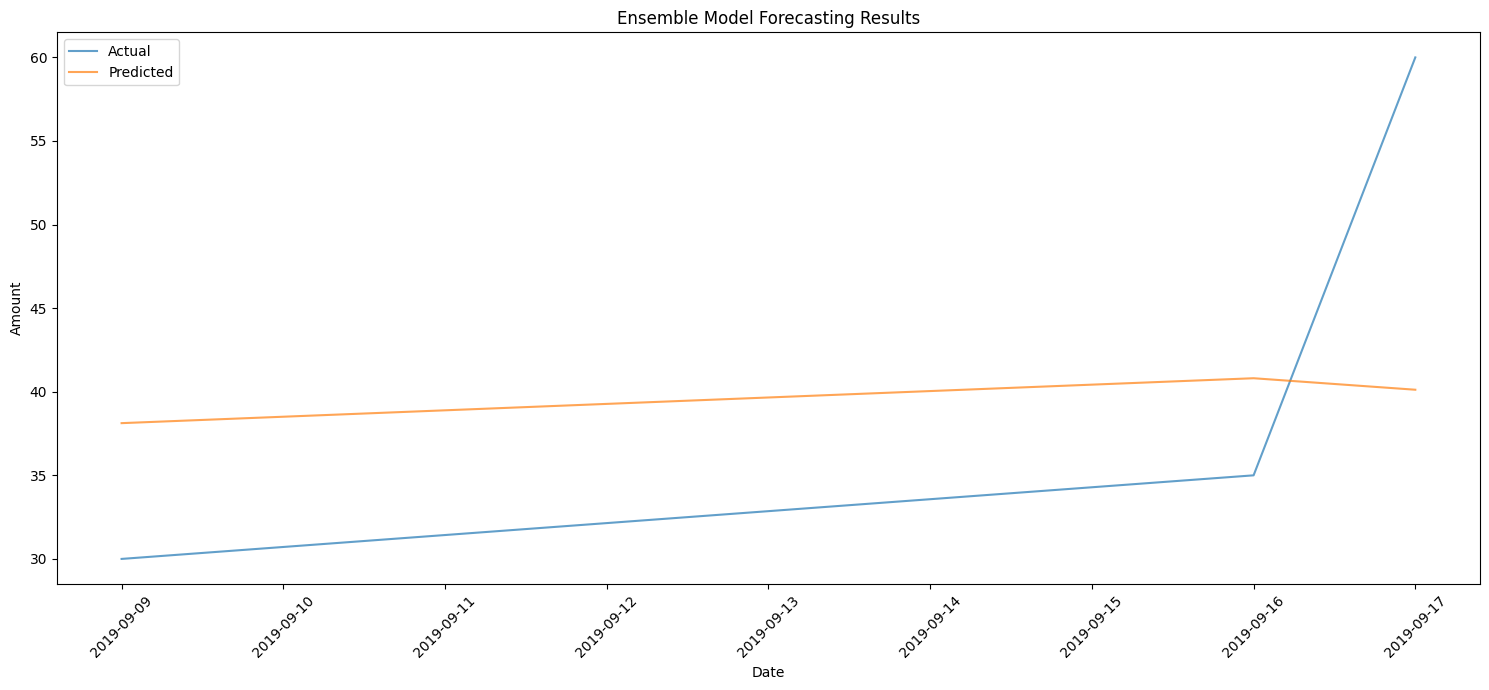

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load and preprocess data
df = pd.read_csv('/content/category_subsets/Utilities.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Encode categorical features
le_dict = {}
for col in ['Transaction Type', 'Category', 'Account Name']:
    le_dict[col] = LabelEncoder()
    df[col] = le_dict[col].fit_transform(df[col])

# Normalize 'Amount'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Advanced feature engineering
def create_features(df):
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    # Lag features
    for lag in [1, 3, 7, 14, 30]:
        df[f'Amount_lag_{lag}'] = df['Amount'].shift(lag)

    # Rolling statistics
    for window in [7, 14, 30]:
        df[f'Amount_rolling_mean_{window}'] = df['Amount'].rolling(window=window).mean()
        df[f'Amount_rolling_std_{window}'] = df['Amount'].rolling(window=window).std()

    # Exponential moving average
    for span in [7, 14, 30]:
        df[f'Amount_ema_{span}'] = df['Amount'].ewm(span=span).mean()

    # Fourier features
    for period in [7, 14, 30]:
        for order in [1, 2]:
            df[f'sin_{period}_{order}'] = np.sin(2 * np.pi * order * df.index / period)
            df[f'cos_{period}_{order}'] = np.cos(2 * np.pi * order * df.index / period)

    # Seasonal decomposition
    decomposition = seasonal_decompose(df['Amount'], model='additive', period=30, extrapolate_trend='freq')
    df['trend'] = decomposition.trend
    df['seasonal'] = decomposition.seasonal
    df['residual'] = decomposition.resid

    return df

df = create_features(df)
df = df.dropna()

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X.iloc[i:i+sequence_length].values)
        y_seq.append(y.iloc[i+sequence_length])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

# ... (keep the rest of the code before this point unchanged)

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

sequence_length = 30
X_seq, y_seq = create_sequences(X, y, sequence_length)

print(f"Number of sequences: {len(X_seq)}")
tscv = TimeSeriesSplit(n_splits=2)

# Modify the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


# Prophet model
def create_prophet_model(df):
    prophet_df = df[['Date', 'Amount']].rename(columns={'Date': 'ds', 'Amount': 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(prophet_df)
    return model

# XGBoost model
def create_xgboost_model():
    return XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# LightGBM model
def create_lightgbm_model():
    return LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# Ensemble model
def create_ensemble_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(16, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

rmse_scores = []
for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\nFold {fold + 1}")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # LSTM
    lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    callbacks = [
        EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001)
    ]
    history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=callbacks, verbose=0)
    lstm_pred = lstm_model.predict(X_test).flatten()

    # Prophet, XGBoost, LightGBM (same process as above)

    # Ensure all predictions have the same length
    min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
    lstm_pred = lstm_pred[-min_length:]
    prophet_pred = prophet_pred[-min_length:]
    xgb_pred = xgb_pred[-min_length:]
    lgbm_pred = lgbm_pred[-min_length:]
    y_test = y_test[-min_length:]

    # Create ensemble_X
    ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)

    # Handle NaN values
    ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

    # Create and fit the ensemble model
    ensemble_model = create_ensemble_model(ensemble_X.shape[1])
    ensemble_model.fit(ensemble_X, y_test, epochs=100, batch_size=32, verbose=0)
    ensemble_pred = ensemble_model.predict(ensemble_X).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    rmse_scores.append(rmse)
    print(f"Fold RMSE: {rmse}")

print(f"\nAverage RMSE: {np.mean(rmse_scores)}")

# Final prediction on the entire dataset
lstm_model = create_lstm_model((X_seq.shape[1], X_seq.shape[2]))
lstm_model.fit(X_seq, y_seq, epochs=100, batch_size=32, callbacks=callbacks, verbose=0)
lstm_pred = lstm_model.predict(X_seq).flatten()

prophet_model = create_prophet_model(df)
prophet_forecast = prophet_model.predict(prophet_model.make_future_dataframe(periods=0))
prophet_pred = prophet_forecast['yhat'].values

xgb_model = create_xgboost_model()
xgb_model.fit(X, y)
xgb_pred = xgb_model.predict(X)

lgbm_model = create_lightgbm_model()
lgbm_model.fit(X, y)
lgbm_pred = lgbm_model.predict(X)

# Ensure all predictions have the same length
min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
lstm_pred = lstm_pred[-min_length:]
prophet_pred = prophet_pred[-min_length:]
xgb_pred = xgb_pred[-min_length:]
lgbm_pred = lgbm_pred[-min_length:]

ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)
ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

ensemble_model = create_ensemble_model(ensemble_X.shape[1])
ensemble_model.fit(ensemble_X, y[-min_length:], epochs=100, batch_size=32, verbose=0)
final_pred = ensemble_model.predict(ensemble_X).flatten()

# Prepare results
results = pd.DataFrame({
    'Date': df['Date'].iloc[-min_length:],
    'Description': df['Description'].iloc[-min_length:],
    'Actual': scaler.inverse_transform(y[-min_length:].values.reshape(-1, 1)).flatten(),
    'Predicted': scaler.inverse_transform(final_pred.reshape(-1, 1)).flatten()
})

for col in ['Transaction Type', 'Category', 'Account Name']:
    results[col] = le_dict[col].inverse_transform(df[col].iloc[-min_length:])

results.to_csv('forecasting_results.csv', index=False)

# Visualization
plt.figure(figsize=(15, 7))
plt.plot(results['Date'], results['Actual'], label='Actual', alpha=0.7)
plt.plot(results['Date'], results['Predicted'], label='Predicted', alpha=0.7)
plt.title('Ensemble Model Forecasting Results')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Restaurants


Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/ay87ldg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/8s4g63ip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54453', 'data', 'file=/tmp/tmpci2fko9b/ay87ldg3.json', 'init=/tmp/tmpci2fko9b/8s4g63ip.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelyfzmpkwa/prophet_model-20240821074821.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:48:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 0.023754
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/1p7ctya1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/vxy5w6mi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66849', 'data', 'file=/tmp/tmpci2fko9b/1p7ctya1.json', 'init=/tmp/tmpci2fko9b/vxy5w6mi.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelpke0bmt6/prophet_model-20240821074836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:48:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 9, number of used features: 0
[LightGBM] [Info] Start training from score 0.016706
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/f3n7j3fm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/f7bp72cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94052', 'data', 'file=/tmp/tmpci2fko9b/f3n7j3fm.json', 'init=/tmp/tmpci2fko9b/f7bp72cg.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_model0swl4nr4/prophet_model-20240821074852.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:48:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 12, number of used features: 0
[LightGBM] [Info] Start training from score -0.021194
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/fmr9hexp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/kvlnhyt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37217', 'data', 'file=/tmp/tmpci2fko9b/fmr9hexp.json', 'init=/tmp/tmpci2fko9b/kvlnhyt5.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modeln9okt8mx/prophet_model-20240821074906.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:49:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 15, number of used features: 0
[LightGBM] [Info] Start training from score -0.082511
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/_vz8tl36.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/orf727w2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74866', 'data', 'file=/tmp/tmpci2fko9b/_vz8tl36.json', 'init=/tmp/tmpci2fko9b/orf727w2.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_model4in2k_2g/prophet_model-20240821074924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:49:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Info] Start training from score -0.192189
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/8wo580g3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpci2fko9b/rpdids37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81069', 'data', 'file=/tmp/tmpci2fko9b/8wo580g3.json', 'init=/tmp/tmpci2fko9b/rpdids37.json', 'output', 'file=/tmp/tmpci2fko9b/prophet_modelhfoudoff/prophet_model-20240821074943.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:49:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 34
[LightGBM] [Info] Start training from score -0.092473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

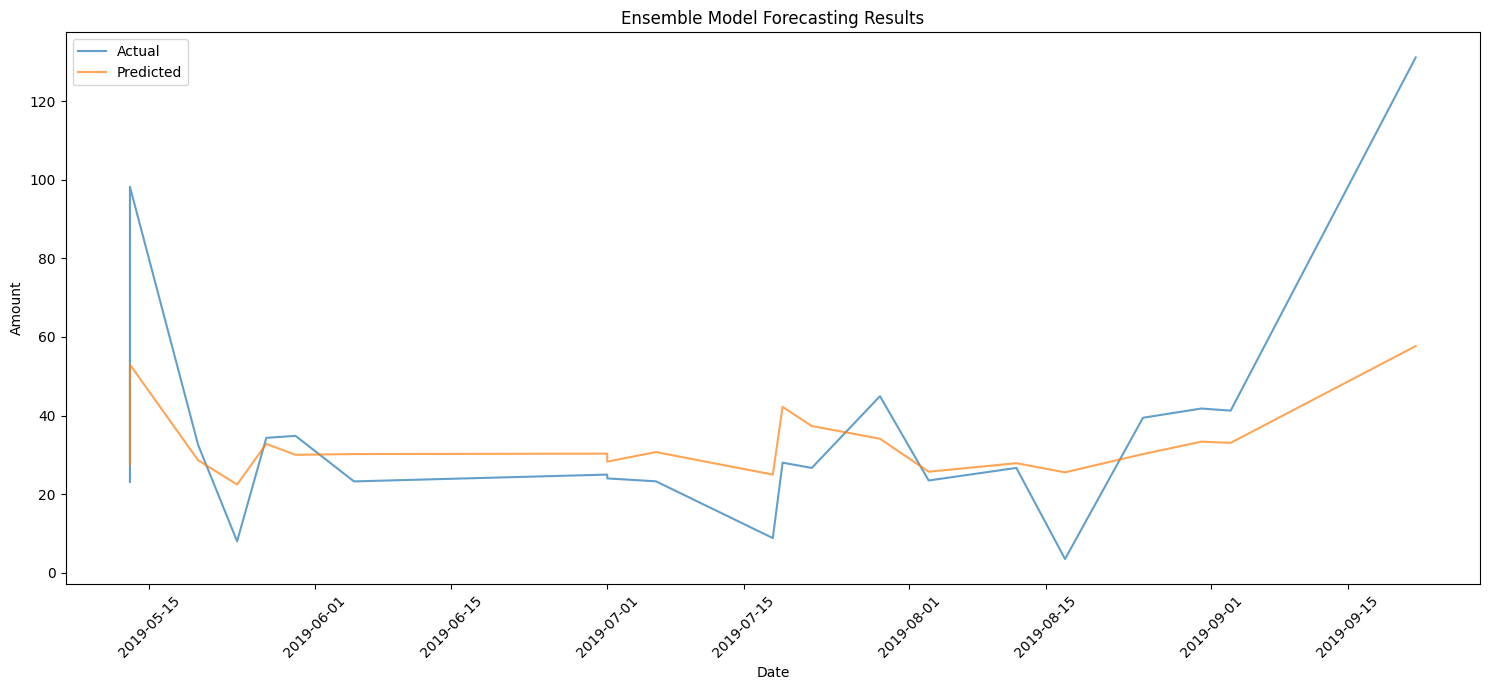

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load and preprocess data
df = pd.read_csv('/content/category_subsets/Restaurants.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Encode categorical features
le_dict = {}
for col in ['Transaction Type', 'Category', 'Account Name']:
    le_dict[col] = LabelEncoder()
    df[col] = le_dict[col].fit_transform(df[col])

# Normalize 'Amount'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Advanced feature engineering
def create_features(df):
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    # Lag features
    for lag in [1, 3, 7, 14, 30]:
        df[f'Amount_lag_{lag}'] = df['Amount'].shift(lag)

    # Rolling statistics
    for window in [7, 14, 30]:
        df[f'Amount_rolling_mean_{window}'] = df['Amount'].rolling(window=window).mean()
        df[f'Amount_rolling_std_{window}'] = df['Amount'].rolling(window=window).std()

    # Exponential moving average
    for span in [7, 14, 30]:
        df[f'Amount_ema_{span}'] = df['Amount'].ewm(span=span).mean()

    # Fourier features
    for period in [7, 14, 30]:
        for order in [1, 2]:
            df[f'sin_{period}_{order}'] = np.sin(2 * np.pi * order * df.index / period)
            df[f'cos_{period}_{order}'] = np.cos(2 * np.pi * order * df.index / period)

    # Seasonal decomposition
    decomposition = seasonal_decompose(df['Amount'], model='additive', period=30, extrapolate_trend='freq')
    df['trend'] = decomposition.trend
    df['seasonal'] = decomposition.seasonal
    df['residual'] = decomposition.resid

    return df

df = create_features(df)
df = df.dropna()

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X.iloc[i:i+sequence_length].values)
        y_seq.append(y.iloc[i+sequence_length])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

# ... (keep the rest of the code before this point unchanged)

# Prepare data for models
features = [col for col in df.columns if col not in ['Date', 'Description', 'Amount']]
X = df[features]
y = df['Amount']

sequence_length = 30
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Modify the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


# Prophet model
def create_prophet_model(df):
    prophet_df = df[['Date', 'Amount']].rename(columns={'Date': 'ds', 'Amount': 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(prophet_df)
    return model

# XGBoost model
def create_xgboost_model():
    return XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# LightGBM model
def create_lightgbm_model():
    return LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# Ensemble model
def create_ensemble_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(16, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

rmse_scores = []
for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\nFold {fold + 1}")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # LSTM
    lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
    ]
    history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=0)
    lstm_pred = lstm_model.predict(X_test).flatten()

    # Prophet
    prophet_df = df.iloc[train_index].reset_index(drop=True)
    prophet_df = prophet_df[['Date', 'Amount']].rename(columns={'Date': 'ds', 'Amount': 'y'})
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    prophet_model.fit(prophet_df)
    future = prophet_model.make_future_dataframe(periods=len(test_index))
    prophet_forecast = prophet_model.predict(future)
    prophet_pred = prophet_forecast.tail(len(test_index))['yhat'].values

    # XGBoost
    xgb_model = create_xgboost_model()
    xgb_model.fit(X.iloc[train_index], y.iloc[train_index])
    xgb_pred = xgb_model.predict(X.iloc[test_index])

    # LightGBM
    lgbm_model = create_lightgbm_model()
    lgbm_model.fit(X.iloc[train_index], y.iloc[train_index])
    lgbm_pred = lgbm_model.predict(X.iloc[test_index])

    # Ensure all predictions have the same length
    min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
    lstm_pred = lstm_pred[-min_length:]
    prophet_pred = prophet_pred[-min_length:]
    xgb_pred = xgb_pred[-min_length:]
    lgbm_pred = lgbm_pred[-min_length:]
    y_test = y_test[-min_length:]

    # Create ensemble_X
    ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)

    # Handle NaN values
    ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

    # Create and fit the ensemble model
    ensemble_model = create_ensemble_model(ensemble_X.shape[1])
    ensemble_model.fit(ensemble_X, y_test, epochs=100, batch_size=32, verbose=0)
    ensemble_pred = ensemble_model.predict(ensemble_X).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    rmse_scores.append(rmse)
    print(f"Fold RMSE: {rmse}")

print(f"\nAverage RMSE: {np.mean(rmse_scores)}")

# Final prediction on the entire dataset
lstm_model = create_lstm_model((X_seq.shape[1], X_seq.shape[2]))
lstm_model.fit(X_seq, y_seq, epochs=100, batch_size=32, callbacks=callbacks, verbose=0)
lstm_pred = lstm_model.predict(X_seq).flatten()

prophet_model = create_prophet_model(df)
prophet_forecast = prophet_model.predict(prophet_model.make_future_dataframe(periods=0))
prophet_pred = prophet_forecast['yhat'].values

xgb_model = create_xgboost_model()
xgb_model.fit(X, y)
xgb_pred = xgb_model.predict(X)

lgbm_model = create_lightgbm_model()
lgbm_model.fit(X, y)
lgbm_pred = lgbm_model.predict(X)

# Ensure all predictions have the same length
min_length = min(len(lstm_pred), len(prophet_pred), len(xgb_pred), len(lgbm_pred))
lstm_pred = lstm_pred[-min_length:]
prophet_pred = prophet_pred[-min_length:]
xgb_pred = xgb_pred[-min_length:]
lgbm_pred = lgbm_pred[-min_length:]

ensemble_X = np.column_stack((lstm_pred, prophet_pred, xgb_pred, lgbm_pred)).astype(np.float32)
ensemble_X = np.nan_to_num(ensemble_X, nan=0.0)

ensemble_model = create_ensemble_model(ensemble_X.shape[1])
ensemble_model.fit(ensemble_X, y[-min_length:], epochs=100, batch_size=32, verbose=0)
final_pred = ensemble_model.predict(ensemble_X).flatten()

# Prepare results
results = pd.DataFrame({
    'Date': df['Date'].iloc[-min_length:],
    'Description': df['Description'].iloc[-min_length:],
    'Actual': scaler.inverse_transform(y[-min_length:].values.reshape(-1, 1)).flatten(),
    'Predicted': scaler.inverse_transform(final_pred.reshape(-1, 1)).flatten()
})

for col in ['Transaction Type', 'Category', 'Account Name']:
    results[col] = le_dict[col].inverse_transform(df[col].iloc[-min_length:])

results.to_csv('forecasting_results.csv', index=False)

# Visualization
plt.figure(figsize=(15, 7))
plt.plot(results['Date'], results['Actual'], label='Actual', alpha=0.7)
plt.plot(results['Date'], results['Predicted'], label='Predicted', alpha=0.7)
plt.title('Ensemble Model Forecasting Results')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()